# Continous images using CNNs

In [1]:
from __future__ import print_function

import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from IPython.display import HTML

Set seed for reproducibility

In [2]:
seed = 999

#manualSeed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)

print(seed)

999


Define data directory and the number of workers

In [3]:
data_directory = "data/Terrain/processed"
n_workers = 2

## Settings and hyper parameters

In [4]:
sample_size  = 512
i_image_size = 512
o_image_size = 1081

n_channels = 1
n_features = 64

n_epochs    = 5
learning_r  = 0.0002
beta1       = 0.5

n_gpus = 1

## Defining the network

In [5]:
class Network(nn.Module):
    def __init__(self, n_gpus):
        super(Network, self).__init__()
        self.n_gpus = n_gpus
        self.main = nn.Sequential(
            # 512 x 512
            nn.Conv2d(n_channels + 2, n_features, 4, stride=1, padding=1),
            nn.BatchNorm2d(n_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # 256 x 256
            nn.Conv2d(n_features, n_features * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # 128 x 128
            nn.Conv2d(n_features * 2, n_features * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # 64 x 64
            nn.Conv2d(n_features * 4, n_features * 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # 32 x 32
            nn.Conv2d(n_features * 8, n_features * 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Flatten(),
            nn.Dropout(),

            nn.Linear(2 * 2 * n_features * 16, 1000),
            nn.ReLU(inplace=True),

            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, n_channels)
        )

    def forward(self, input):
        return self.main(input).float()

## Loading the Dataset

In [6]:
dataset_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(o_image_size),
    transforms.CenterCrop(o_image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = dset.ImageFolder(root=data_directory, transform=dataset_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True, num_workers=n_workers)

In [7]:
run_cuda = torch.cuda.is_available() and n_gpus > 0 
device   = torch.device("cuda:0" if run_cuda else "cpu")

print(run_cuda, torch.cuda.is_available())

True True


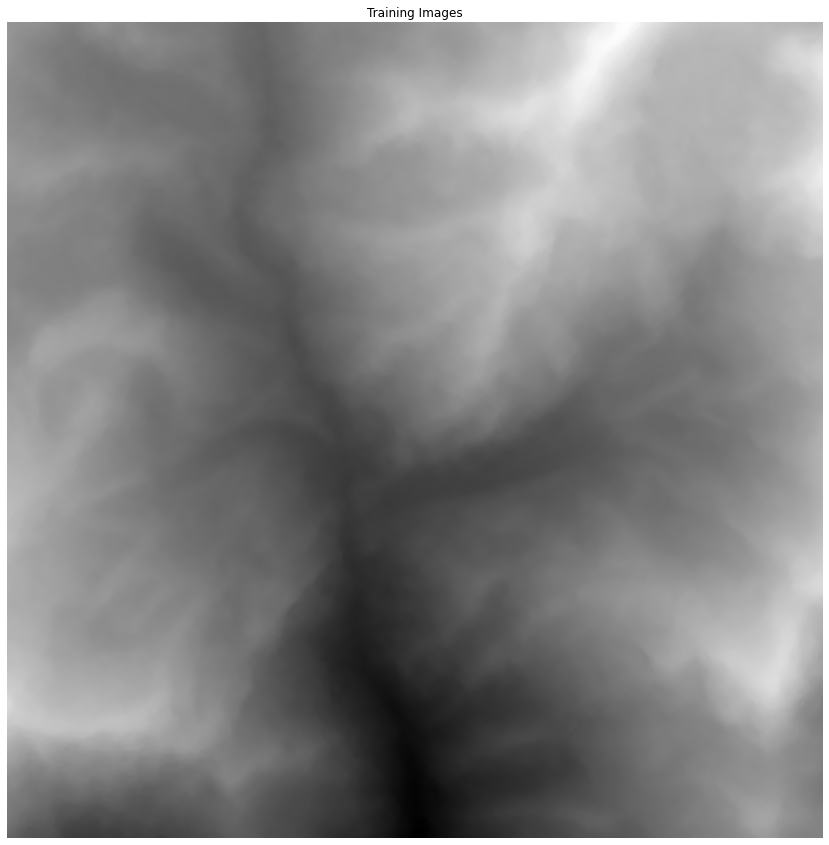

In [8]:
batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [9]:
def save_img(image, name):
    array = array.detach()
    array = array.reshape(28,28)
    
    plt.imshow(immage, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('output/' + name)

In [10]:
network = Network(n_gpus).to(device)

if device.type is 'cuda' and n_gpus > 1:
    network = nn.DataParallel(n_gpus, list(range(n_gpus)))

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001, betas=(beta1, 0.999))

In [13]:
loss_log = []
iters, start_epoch = 0, 0

restore_session = True
runtime = ''

start_time = datetime.now()

In [14]:
def print_progress(line):
    with open('out.txt', 'w') as file:
        file.write(line)

In [15]:
def save_session(cur_epoch, cur_iters, cur_time):
    net_state = { 'state_dict': network.state_dict(), 'optimizer': optimizer.state_dict() }
    log_state = { 'iters': cur_iters, 'epoch': cur_epoch + 1, 'runtime': cur_time, 'loss': loss_log }

    state = { 'net_state': net_state, 'log_state': log_state }
    torch.save(state, 'checkpoints/css/latest.pth.tar')

In [16]:
def load_session(filename='checkpoints/css/latest.pth.tar'):
    if os.path.isfile(filename):
        print('=> Loading checkpoint from {}'.format(filename))
        checkpoint = torch.load(filename)
        return checkpoint
    else:
        print('=> Checkpoint {} not found'.format(filename))

In [19]:
if os.path.isfile('checkpoints/css/latest.pth.tar') and restore_session:
    session = load_session('checkpoints/css/latest.pth.tar')

    # Load logs
    loss_log = session['log_state']['loss']
    iters, start_epoch = session['log_state']['iters'], session['log_state']['epoch']
    runtime = session['log_state']['runtime']

    # Load network
    network.load_state_dict(session['net_state']['state_dict'])
    optimizer.load_state_dict(session['net_state']['optimizer'])

    dt = datetime.strptime(runtime, '%H:%M:%S')
    runtime_delta = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    start_time = start_time - runtime_delta

=> Loading checkpoint from checkpoints/css/latest.pth.tar


In [18]:
# Start training
for epoch in range(start_epoch, n_epochs):
    for i, image in enumerate(dataloader):
        for j in range(sample_size):
            network.zero_grad()

            x_space = random.uniform(0, 1)
            y_space = random.uniform(0, 1)

            input_tensor = torch.Tensor([[batch[0][0][0].numpy(),
                                            np.full((o_image_size, o_image_size), x_space),
                                            np.full((o_image_size, o_image_size), y_space)]])

            x_coordinate = int(x_space * o_image_size)
            y_coordinate = int(y_space * o_image_size)

            label = torch.tensor([image[0][0][0][y_coordinate][x_coordinate]], dtype=torch.float)
            output = network(input_tensor.to(device))

            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()

            runtime = str(datetime.now() - start_time).split('.')[:1][0]

            if j % 5 is 0:
                print_progress('Runtime: \e[32m%s\e[0m\n\n[\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m] loss: \e[32m%.4f\e[0m CUDA: \e[32m%s\e[0m' %
                    (runtime, epoch + 1, n_epochs, i, len(dataloader), j, sample_size, iters, loss.item(), run_cuda))
        
            loss_log.append(loss.item())

            if (iters % 1000 is 0 and i is not 0) or (epoch is n_epochs - 1 and i == len(dataloader) - 1):
                save_session(epoch, iters, runtime)

            iters += 1

KeyboardInterrupt: 

In [11]:
x_space = random.uniform(0, 1)
y_space = random.uniform(0, 1)

input_tensor = torch.Tensor([[batch[0][0][0].numpy(),
                                np.full((o_image_size, o_image_size), x_space),
                                np.full((o_image_size, o_image_size), y_space)]])

x_coordinate = int(x_space * o_image_size)
y_coordinate = int(y_space * o_image_size)

with torch.no_grad():
    output = network(input_tensor.to(device))

label = batch[0][0][0][y_coordinate][x_coordinate]
print(label, output.to('cpu')[0][0])